In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install yfinance
import yfinance as yf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.2 MB/s eta 0:00:00


In [4]:
gld = yf.Ticker("GLD")
gdx = yf.Ticker("GDX")

gld_history = gld.history(period="3y")
gdx_history = gdx.history(period="3y")

In [5]:
history = pd.merge(
    gld_history[["Close"]], gdx_history[["Close"]], 
    left_index=True, right_index=True, 
    suffixes=('_GLD', '_GDX')
)
history

,Close_GLD,Close_GDX
Date,,
2020-05-06 00:00:00-04:00,158.949997,32.400425
2020-05-07 00:00:00-04:00,161.389999,33.679134
2020-05-08 00:00:00-04:00,160.419998,33.515694
2020-05-11 00:00:00-04:00,159.419998,32.583096
2020-05-12 00:00:00-04:00,160.039993,32.535027
...,...,...
2023-05-01 00:00:00-04:00,183.970001,33.410000
2023-05-02 00:00:00-04:00,187.520004,34.740002
2023-05-03 00:00:00-04:00,189.110001,34.860001


/tmp/ipykernel_34/3803630963.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


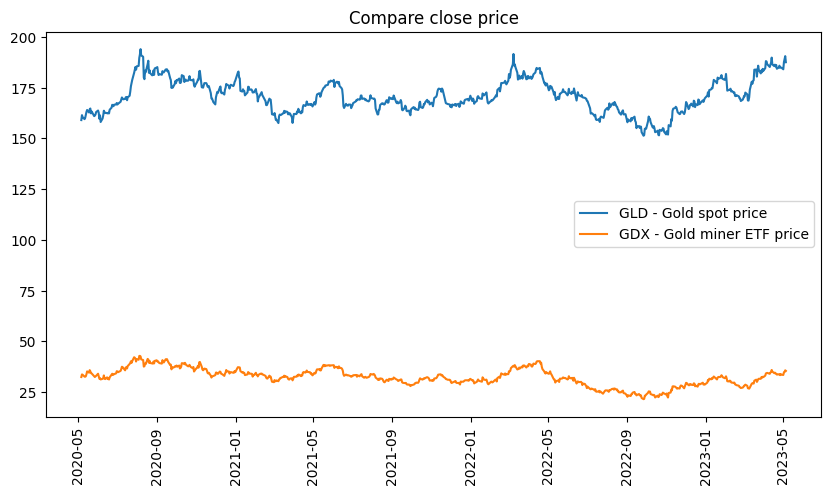

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[10, 5])

ax.plot(history.Close_GLD, label="GLD - Gold spot price")
ax.plot(history.Close_GDX, label="GDX - Gold miner ETF price")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Compare close price")
ax.legend()

In [7]:
import statsmodels.api as sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Build train and test set for backtesting strategy. All parameters are estimated on the train set.

In [8]:
trainset = np.arange(0, 252 * 2)
testset = np.arange(trainset.shape[0], history.shape[0])
print("Train set range: ", np.min(trainset), ",", np.max(trainset))
print("Test set range: ", np.min(testset), ",", np.max(testset))

Train set range:  0 , 503
Test set range:  504 , 755


Use a regression to find hedge ratio between GDX and GLD on the train set. In this example the spread ratio is used to normalize the price spread and to find trading signals.

In [9]:
model = sm.OLS(
    history.loc[:, "Close_GLD"].iloc[trainset],
    history.loc[:, "Close_GDX"].iloc[trainset]
)
results = model.fit()

hedge_ratio = results.params["Close_GDX"] 
print("Hedge ratio: %.2f" % hedge_ratio)

Hedge ratio: 4.99


In [10]:
# Hedge = GLD - hedge_ratio * GDX
spread = history.loc[:, "Close_GLD"] - hedge_ratio * history.loc[:, "Close_GDX"]

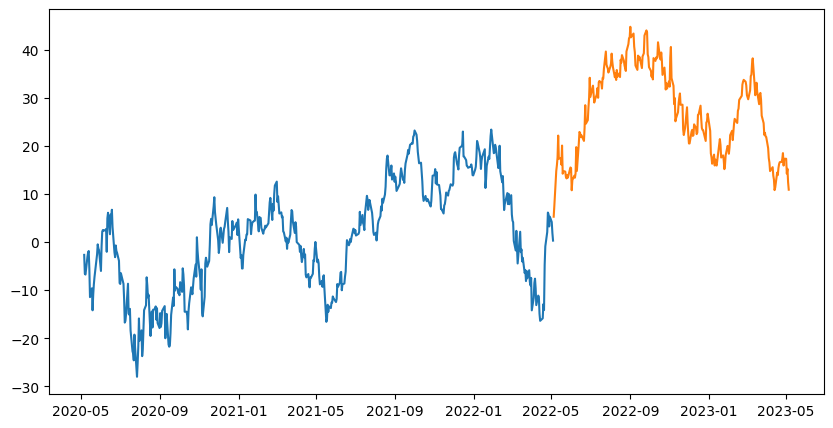

In [11]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(spread.iloc[trainset])
ax.plot(spread.iloc[testset])

Text(0.5, 1.0, 'Spread density')

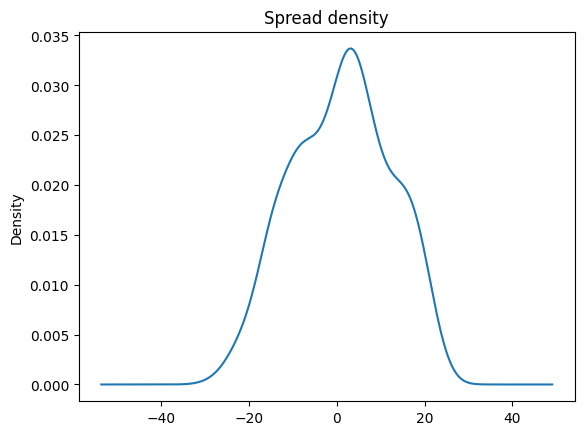

In [12]:
# Spread 
ax = spread.iloc[trainset].plot.kde()
ax.set_title("Spread density")

In [13]:
spread_mean = np.mean(spread.iloc[trainset])
spread_std = np.std(spread.iloc[trainset])
print(f"Spread mean: {spread_mean:.4f}")
print(f"Spread std: {spread_std:.4f}")

Spread mean: 0.9924
Spread std: 11.1835


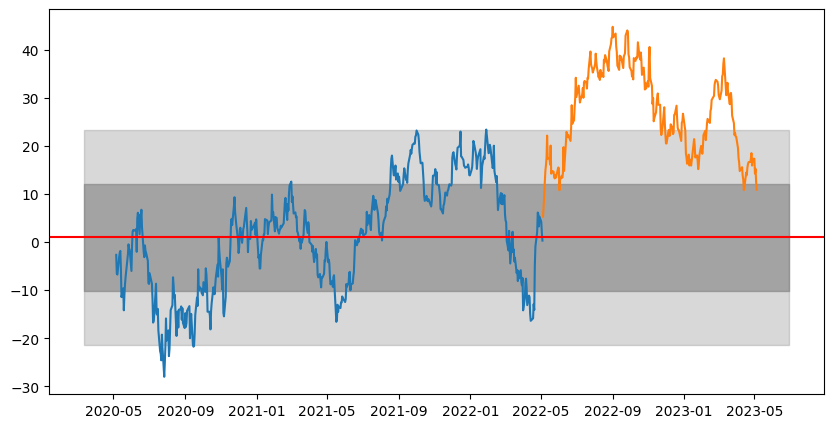

In [14]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(spread.iloc[trainset])
ax.plot(spread.iloc[testset])
ax.axhline(spread_mean, color="red")
z2_upper, z2_lower = spread_mean  + 2 * spread_std, spread_mean - 2 * spread_std
z1_upper, z1_lower = spread_mean  + 1 * spread_std, spread_mean - 1 * spread_std
x_min, x_max = ax.get_xlim()
ax.fill_between([x_min, x_max], z2_upper, z2_lower, alpha=0.3, color="gray")
ax.fill_between([x_min, x_max], z1_upper, z1_lower, alpha=0.6, color="gray")

In [15]:
# Use spread z-score to find trading signals
history["zscore"] = (spread - spread_mean) / spread_std
history["positions_GLD_Long"] = 0
history["positions_GDX_Long"] = 0
history["positions_GLD_Short"] = 0
history["positions_GDX_Short"] = 0

Perform short spread when the spread is more than 2 std away from its mean. In this case GLD is potentially over-priced. Short GLD and long GDX.

Perform long spread when the spread is more than -2 std away from its mean. In this case GLD is potentially under-priced. Long GLD and short GDX.

In [20]:

history.loc[history.zscore >= 1, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1] # Short spread
history.loc[history.zscore <= -1, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1] # Buy spread
history.loc[history.zscore <= 0.5, ('positions_GLD_Short', 'positions_GDX_Short')] = 0 # Exit short spread
history.loc[history.zscore >= -0.5, ('positions_GLD_Long', 'positions_GDX_Long')] = 0 # Exit long spread
history.fillna(method="ffill", inplace=True) # Ensure existing positions are carried forward unless there is an exit signal
history

,Close_GLD,Close_GDX,zscore,positions_GLD_Long,positions_GDX_Long,positions_GLD_Short,positions_GDX_Short
Date,,,,,,,
2020-05-06 00:00:00-04:00,158.949997,32.400425,-0.325577,0,0,0,0
2020-05-07 00:00:00-04:00,161.389999,33.679134,-0.677670,0,0,0,0
2020-05-08 00:00:00-04:00,160.419998,33.515694,-0.691514,0,0,0,0
2020-05-11 00:00:00-04:00,159.419998,32.583096,-0.365017,0,0,0,0
2020-05-12 00:00:00-04:00,160.039993,32.535027,-0.288141,0,0,0,0
...,...,...,...,...,...,...,...
2023-05-01 00:00:00-04:00,183.970001,33.410000,1.461404,0,0,-1,1
2023-05-02 00:00:00-04:00,187.520004,34.740002,1.185690,0,0,-1,1
2023-05-03 00:00:00-04:00,189.110001,34.860001,1.274347,0,0,-1,1


In [21]:
positions_Long = history.loc[:, ("positions_GLD_Long", "positions_GDX_Long")]
positions_Short = history.loc[:, ("positions_GLD_Short", "positions_GDX_Short")]
positions = pd.DataFrame(np.array(positions_Long) + np.array(positions_Short), index=history.index)
positions

,0,1
Date,,
2020-05-06 00:00:00-04:00,0,0
2020-05-07 00:00:00-04:00,0,0
2020-05-08 00:00:00-04:00,0,0
2020-05-11 00:00:00-04:00,0,0
2020-05-12 00:00:00-04:00,0,0
...,...,...
2023-05-01 00:00:00-04:00,-1,1
2023-05-02 00:00:00-04:00,-1,1
2023-05-03 00:00:00-04:00,-1,1


In [22]:
dailyret = history.loc[:, ("Close_GLD", "Close_GDX")].pct_change()
dailyret

,Close_GLD,Close_GDX
Date,,
2020-05-06 00:00:00-04:00,NaN,NaN
2020-05-07 00:00:00-04:00,0.015351,0.039466
2020-05-08 00:00:00-04:00,-0.006010,-0.004853
2020-05-11 00:00:00-04:00,-0.006234,-0.027826
2020-05-12 00:00:00-04:00,0.003889,-0.001475
...,...,...
2023-05-01 00:00:00-04:00,-0.004491,-0.005063
2023-05-02 00:00:00-04:00,0.019297,0.039808
2023-05-03 00:00:00-04:00,0.008479,0.003454


The Sharpe on trainset is more significant than test set sharpe. This strategy is overfitted on the trainset.

In [25]:
pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1) # Profit and loss
sharpe_trainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]])
sharpe_testset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])

print("Train Sharpe %.4f" % sharpe_trainset)
print("Test Sharpe %.4f" % sharpe_testset)

Train Sharpe 1.6344
Test Sharpe 0.4724


The pair trading strategy using +/- 1 std as trading signals, and +/- 0.5 std as the exit signals over fits to the train set. At the end of train set, this strategy achieved 150% profitability. At the end of test set, this strategy only achieved 110% profitability.

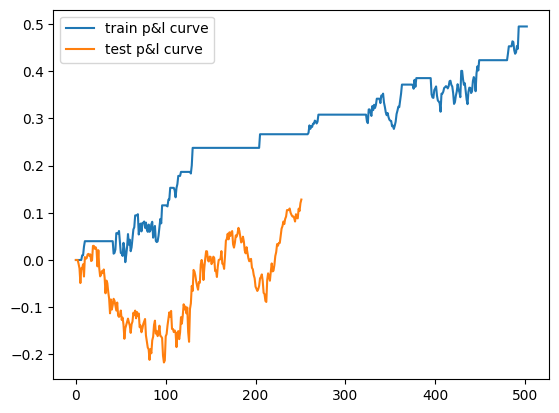

In [28]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pnl[trainset[1:]]), label="train p&l curve")
ax.plot(np.cumsum(pnl[testset]), label="test p&l curve")
ax.legend()
